## Sequence-to-Sequence Text Summarization with LSTM

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Data Preparation
 Let's create a small dataset of news articles and their summaries

In [2]:
data = {
    'article': [
        "Scientists have discovered a new species of dinosaur in Argentina. The fossil remains suggest it was a large herbivore that lived about 90 million years ago. The discovery was made by a team of paleontologists from the National University of La Matanza.",
        "The stock market reached record highs today as tech companies reported better-than-expected earnings. The NASDAQ composite rose by 3.2%, marking its best day in six months. Analysts attribute the surge to positive economic indicators and strong consumer spending.",
        "A major breakthrough in renewable energy was announced today. Researchers have developed a solar panel that is 50% more efficient than current models while being cheaper to produce. The new technology could significantly reduce the cost of solar energy worldwide.",
        "The city council approved a new budget that includes funding for three new schools and improvements to public transportation. The $2.3 billion budget passed with a 7-2 vote after months of negotiations between city officials and community groups.",
        "An international team of climbers successfully reached the summit of Mount Everest yesterday. The group, which included climbers from five different countries, took advantage of favorable weather conditions to complete their ascent. This marks the first successful summit of the season."
    ],
    'summary': [
        "New dinosaur species discovered in Argentina.",
        "Stock market hits record high on strong tech earnings.",
        "Breakthrough in solar panel efficiency announced.",
        "City council approves budget with school and transit funding.",
        "International team summits Mount Everest."
    ]
}

In [3]:
df = pd.DataFrame(data)


In [4]:
# expandind dataset
def expand_dataset(base_df, num_copies=20):
    expanded_data = {'article': [], 'summary': []}
    for i in range(num_copies):
        for _, row in base_df.iterrows():
            # Create slight variations of the text
            article = row['article'].replace(".", ". ").replace("  ", " ").strip()
            summary = row['summary'].replace(".", ". ").replace("  ", " ").strip()

            # Add some simple variations
            if i % 3 == 0:
                article = article.lower()
                summary = summary.lower()
            elif i % 3 == 1:
                article = article.capitalize()
                summary = summary.capitalize()

            expanded_data['article'].append(article)
            expanded_data['summary'].append(summary)
    return pd.DataFrame(expanded_data)

In [5]:
df = expand_dataset(df, num_copies=20)  # Creates 100 samples (5 originals * 20)
print(f"Dataset size: {len(df)}")
df.head()


Dataset size: 100


,article,summary
0,scientists have discovered a new species of di...,new dinosaur species discovered in argentina.
1,the stock market reached record highs today as...,stock market hits record high on strong tech e...
2,a major breakthrough in renewable energy was a...,breakthrough in solar panel efficiency announced.
3,the city council approved a new budget that in...,city council approves budget with school and t...
4,an international team of climbers successfully...,international team summits mount everest.


## Text processing

In [6]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [13]:
nltk.download('punkt', quiet=True)  # This downloads the main Punkt tokenizer
nltk.download('stopwords', quiet=True)

True

In [14]:
print("Punkt available:", nltk.data.find('tokenizers/punkt'))
print("Stopwords available:", nltk.data.find('corpora/stopwords'))

Punkt available: /root/nltk_data/tokenizers/punkt
Stopwords available: /root/nltk_data/corpora/stopwords


In [18]:
!pip uninstall -y nltk
!pip install --upgrade nltk

Found existing installation: nltk 3.9.1
Uninstalling nltk-3.9.1:
  Successfully uninstalled nltk-3.9.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.7 MB/s eta 0:00:00


In [19]:
import nltk
nltk.download('all', force=True, quiet=True)  # This downloads everything

True

In [20]:
# 3. Verify punkt specifically
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    print("✓ All Punkt resources verified")
except:
    print("⚠️ Continuing with fallback method")

✓ All Punkt resources verified


In [21]:
# Apply preprocessing
df['processed_article'] = df['article'].apply(preprocess_text)
df['processed_summary'] = df['summary'].apply(preprocess_text)

In [22]:
df['processed_summary'] = 'sostok ' + df['processed_summary'] + ' eostok'

In [23]:
df.head()

,article,summary,processed_article,processed_summary
0,scientists have discovered a new species of di...,new dinosaur species discovered in argentina.,scientists discovered new species dinosaur arg...,sostok new dinosaur species discovered argenti...
1,the stock market reached record highs today as...,stock market hits record high on strong tech e...,stock market reached record highs today tech c...,sostok stock market hits record high strong te...
2,a major breakthrough in renewable energy was a...,breakthrough in solar panel efficiency announced.,major breakthrough renewable energy announced ...,sostok breakthrough solar panel efficiency ann...
3,the city council approved a new budget that in...,city council approves budget with school and t...,city council approved new budget includes fund...,sostok city council approves budget school tra...
4,an international team of climbers successfully...,international team summits mount everest.,international team climbers successfully reach...,sostok international team summits mount everes...


## 2. Tokenization and Sequence Preparation

In [24]:
# Prepare tokenizers
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(df['processed_article'])

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(df['processed_summary'])

In [25]:
# Convert texts to sequences
x_seq = x_tokenizer.texts_to_sequences(df['processed_article'])
y_seq = y_tokenizer.texts_to_sequences(df['processed_summary'])

In [26]:
# Calculate max lengths
max_article_len = max([len(x) for x in x_seq])
max_summary_len = max([len(y) for y in y_seq])

print(f"Max article length: {max_article_len}")
print(f"Max summary length: {max_summary_len}")

Max article length: 28
Max summary length: 10


In [27]:
# Pad sequences
x_padded = pad_sequences(x_seq, maxlen=max_article_len, padding='post')
y_padded = pad_sequences(y_seq, maxlen=max_summary_len, padding='post')

# Vocabulary sizes
x_vocab_size = len(x_tokenizer.word_index) + 1
y_vocab_size = len(y_tokenizer.word_index) + 1

print(f"Article vocabulary size: {x_vocab_size}")
print(f"Summary vocabulary size: {y_vocab_size}")


Article vocabulary size: 113
Summary vocabulary size: 33


In [28]:
# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_padded, test_size=0.2, random_state=42)

## 3. Model Building

In [29]:
# Encoder
latent_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_article_len,))
enc_emb = Embedding(x_vocab_size, latent_dim, trainable=True)(encoder_inputs)

In [30]:
# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [31]:
# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_vocab_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)


In [32]:
# LSTM for decoder
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [33]:
# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

In [34]:
# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 28, 300)   │     33,900 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 28, 300), │    721,200 │ embedding[0][0]   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 28, 300), │    721,200 │ lstm[0][0]        │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │      9,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 28, 300), │    721,200 │ lstm_1[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    721,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 33)  │      9,933 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,938,533 (11.21 MB)

 Trainable params: 2,938,533 (11.21 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## 4. Model Training
Prepare decoder input and output data
For training, we use teacher forcing where the input to the decoder is the previous word from the true output

In [36]:
y_train_decoder_input = y_train[:, :-1]
y_train_decoder_output = y_train[:, 1:]  # Offset by 1

y_test_decoder_input = y_test[:, :-1]
y_test_decoder_output = y_test[:, 1:]

In [37]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [38]:
# Train the model
history = model.fit(
    [x_train, y_train_decoder_input],
    np.expand_dims(y_train_decoder_output, -1),
    batch_size=16,
    epochs=30,
    validation_data=([x_test, y_test_decoder_input], np.expand_dims(y_test_decoder_output, -1)),
    callbacks=[early_stopping]
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 627ms/step - accuracy: 0.2556 - loss: 3.4438 - val_accuracy: 0.2722 - val_loss: 3.0029
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 472ms/step - accuracy: 0.2797 - loss: 2.7242 - val_accuracy: 0.3278 - val_loss: 2.0786
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.4343 - loss: 1.8965 - val_accuracy: 0.5611 - val_loss: 1.5527
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.6647 - loss: 1.3426 - val_accuracy: 0.7056 - val_loss: 1.1823
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.7997 - loss: 1.0392 - val_accuracy: 0.9333 - val_loss: 0.7994
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.9514 - loss: 0.7117 - val_accuracy: 1.0000 - val_loss: 0.5481
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - accuracy: 1.0000 - loss: 0.5404 - val_accuracy: 1.0000 - val_loss: 0.3847
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 1.0000 - loss: 0.3180 - val_accuracy: 1.0000 - val_loss

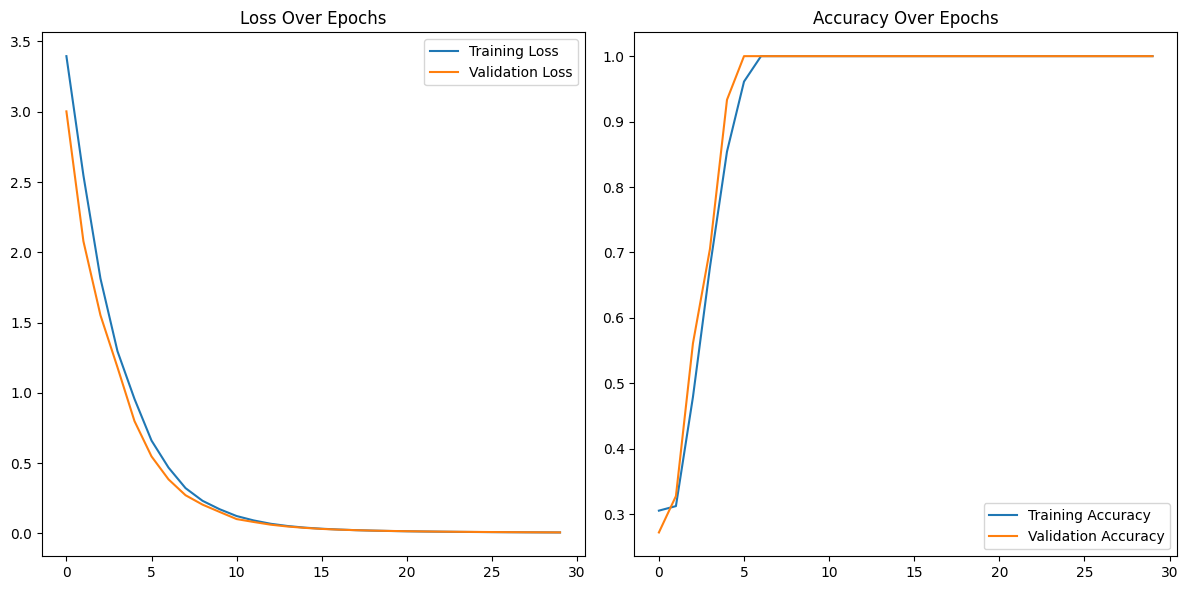

In [39]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Inference Setup

In [40]:
# Encoder inference model
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, state_h, state_c]
)

In [41]:
# Decoder inference model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_article_len, latent_dim))

dec_emb_inf = dec_emb_layer(decoder_inputs)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    dec_emb_inf,
    initial_state=[decoder_state_input_h, decoder_state_input_c]
)
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf] + [state_h_inf, state_c_inf]
)

## 6. Prediction Function

In [42]:
def decode_sequence(input_seq):
    # Encode the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1 with only the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = y_tokenizer.word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = y_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop token
        if (sampled_token == 'eostok' or
            len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.strip()

## 7. Model Evaluation

In [43]:
# Function to convert sequence to text
def seq_to_text(sequence, tokenizer):
    words = []
    for idx in sequence:
        if idx == 0:  # Padding
            continue
        word = tokenizer.index_word.get(idx, '')
        if word:
            words.append(word)
    return ' '.join(words)

In [45]:
# Test the model on some samples from the test set
for i in range(5):
    print(f"\nSample {i+1}")
    print("Original Article:")
    print(seq_to_text(x_test[i], x_tokenizer))
    print("\nOriginal Summary:")
    print(seq_to_text(y_test[i], y_tokenizer).replace('sostok', '').replace('eostok', '').strip())

    input_seq = x_test[i].reshape(1, max_article_len)
    predicted_summary = decode_sequence(input_seq)
    print("\nPredicted Summary:")
    print(predicted_summary)
    print("="*50)


Sample 1
Original Article:
city council approved new budget includes funding three new schools improvements public transportation billion budget passed vote months negotiations city officials community groups

Original Summary:
city council approves budget school transit funding
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Predicted Summary:
city council approves budget school transit funding

Sample 2
Original Article:
city council approved new budget includes funding three new schools improvements public transportation billion budget passed vote months negotiations city officials community groups

Original Summary:
city council approves budget school transit funding
1/1 ━━━━━━━━━━━━━━━━━━

## 8. Custom Input Testing

In [46]:
def predict_summary(text):
    # Preprocess
    processed_text = preprocess_text(text)
    # Tokenize
    seq = x_tokenizer.texts_to_sequences([processed_text])
    # Pad
    padded = pad_sequences(seq, maxlen=max_article_len, padding='post')
    # Predict
    summary = decode_sequence(padded.reshape(1, max_article_len))
    return summary

In [47]:
# Test with custom input
test_article = """
The president announced a new economic stimulus package today worth over $1 trillion.
The package includes direct payments to citizens, extended unemployment benefits,
and funding for infrastructure projects. Economists say this could help boost the
recovery from the recent recession.
"""

print("Custom Article:")
print(test_article)
print("\nGenerated Summary:")
print(predict_summary(test_article))

Custom Article:

The president announced a new economic stimulus package today worth over $1 trillion. 
The package includes direct payments to citizens, extended unemployment benefits, 
and funding for infrastructure projects. Economists say this could help boost the 
recovery from the recent recession.


Generated Summary:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
new dinosaur species discovered argentina
